In [378]:
import numpy
import sklearn
import scipy
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
import numpy as np
from scipy.optimize import minimize
import matplotlib
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import torch.utils.data as data_utils
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.preprocessing import StandardScaler
import torchvision
from torchvision.transforms import transforms
from sklearn.decomposition import PCA, FastICA
from ERM import sklearn_optimize, error, adversarial_error
from helpers import ProblemType
from data_model import KFeaturesModel
import logging
logger = logging.getLogger()


%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [379]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [380]:
plt.style.use("latex_ready.mplstyle")

In [381]:
def cifar10_plot(ax, im, label):
    
    im_r = im[0:1024].reshape(32, 32)
    im_g = im[1024:2048].reshape(32, 32)
    im_b = im[2048:].reshape(32, 32)

    img = np.dstack((im_r, im_g, im_b))
    
    ax.imshow(img,  interpolation='nearest') 
    if hasattr(ax,"set_title"):
        ax.set_title(label)
    elif hasattr(ax,"title"):
        ax.title(label)
    else:
        raise ValueError("Unable to set title")
    ax.axis("off")

In [382]:
def plot_cifar10_subset(data, labels, subset: str):
    # display some random images from both classes including a label for each image
    fig, ax = plt.subplots(2, 5)
    fig.suptitle(f"Random images from the {subset} dataset")
    for i in range(2):
        for j in range(5):
            idx = np.random.randint(0, data.shape[0])
            

            cifar10_plot(ax[i, j], data[idx], labels[idx])               
                       
            
    plt.show()

In [383]:
FIRST_LABEL = 3
SECOND_LABEL = 1
def preprocess_cifar10_data_labels(data, labels, subset):
    labels = np.array(labels)
    data = np.array(data)
    
    print(subset, labels.shape, data.shape)

    mask = (labels == FIRST_LABEL) | (labels == SECOND_LABEL)
    label_subset = labels[mask]
    data_subset = data[mask]
        
    mask_first = label_subset == FIRST_LABEL
    mask_second = label_subset == SECOND_LABEL
    
    # label the FIRST_LABEL as 1
    # label the SECOND_LABEL as -1
    label_subset[mask_first] = 1
    label_subset[mask_second] = -1

    plot_cifar10_subset(data_subset, label_subset, subset)    

    return data_subset, label_subset


In [384]:
def prepare_cifar10_data():
    # get test data
    cifar_10_test_data = unpickle("./data/cifar-10-batches-py/test_batch")[b"data"]
    cifar_10_test_labels = unpickle("./data/cifar-10-batches-py/test_batch")[b"labels"]

    cifar_10_test_data, cifar_10_test_labels = preprocess_cifar10_data_labels(cifar_10_test_data, cifar_10_test_labels, "test:")

    # merge train data
    cifar_10_data = []
    cifar_10_labels = []
    for i in range(1,6):
        data = unpickle("./data/cifar-10-batches-py/data_batch_"+str(i))
        cifar_10_data.append(data[b'data'])
        cifar_10_labels += data[b'labels']
    cifar_10_data = np.concatenate(cifar_10_data)

    cifar_10_data, cifar_10_labels = preprocess_cifar10_data_labels(cifar_10_data, cifar_10_labels, "train:")

    X = StandardScaler().fit(cifar_10_data).transform(cifar_10_data)
    X_test = StandardScaler().fit(cifar_10_test_data).transform(cifar_10_test_data)
    # X = cifar_10_data
    # X_test = cifar_10_test_data

    return X, X_test, cifar_10_labels, cifar_10_test_labels

test: (10000,) (10000, 3072)


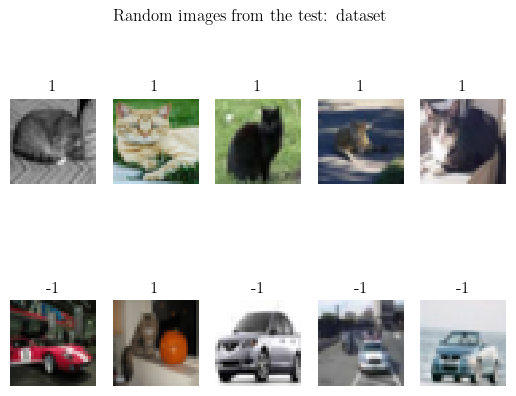

train: (50000,) (50000, 3072)


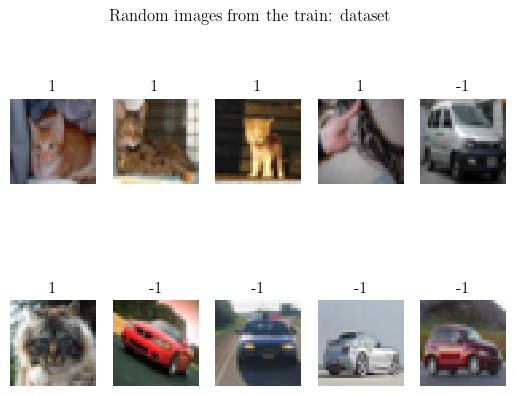

In [385]:
X, X_test, y, y_test = prepare_cifar10_data()

# FastICA

In [386]:
def ica_fit_transform(X, X_test, n_components, whiten="unit-variance"):
    ica = FastICA(n_components=n_components, whiten=whiten, max_iter=1000)
    ica.fit(X)
    X_train_transformed = ica.transform(X)
    X_test_transformed = ica.transform(X_test)
    return X_train_transformed, X_test_transformed

def pca_fit_transform(X, X_test, n_components):
    pca = PCA(n_components=n_components)
    pca.fit(X)
    X_train_transformed = pca.transform(X)
    X_test_transformed = pca.transform(X_test)
    return X_train_transformed, X_test_transformed


In [387]:
X_tr, X_tr_test = ica_fit_transform(X, X_test, n_components=500)
# X_tr, X_tr_test = pca_fit_transform(X, X_test, n_components=300)
# X_tr, X_tr_test = X, X_test


In [388]:

def evaluate(w, X_train, X_test, y_train, y_test, attack_epsilon, sigma_upsilon):

    # compute y pred train
    y_pred_train = np.sign(np.dot(X_train, w))
    # compute y pred test
    y_pred_test = np.sign(np.dot(X_test, w))
    # evaluate error and adversarial error, format as percentages to 4 decimal places
    print(f"Training error: {error(y_pred_train, y_train):.5f}")
    print(f"Test error: {error(y_pred_test, y_test):.5f}")
    print(f"Adversarial error: {adversarial_error(y_test, X_test, w, attack_epsilon, sigma_upsilon):.5f}")

def optimize_adversarial_problem(X_train, y_train, X_test, y_test, lam, epsilon, attack_epsilon, sigma_upsilon = None,sigma_delta = None):
    problem_type = ProblemType.Logistic
    d = X_train.shape[1]
    w = np.ones(d)/d**2

    if sigma_delta is None:
        sigma_delta = np.diag(np.ones(d))

    if sigma_upsilon is None:
        sigma_upsilon = np.diag(np.ones(d))

    weights, _ = sklearn_optimize(w, X_train, y_train, lam, epsilon, problem_type,sigma_delta=sigma_delta)

    # lg = LogisticRegression()
    # lg.fit(X_train, y_train)

    # weights = lg.weights

    evaluate(weights, X_train, X_test, y_train, y_test, attack_epsilon, sigma_upsilon)

    return weights

In [389]:
lam = 0.01
epsilon = 0
attack_epsilon = 1
d = X_tr.shape[1]
sigma_upsilon = np.diag(np.ones(d))
sigma_delta = np.diag(np.ones(d))
w = optimize_adversarial_problem(X_tr, y, X_tr_test, y_test, lam=lam, epsilon = epsilon, attack_epsilon = attack_epsilon, sigma_upsilon=sigma_upsilon, sigma_delta=sigma_delta)

Training error: 0.15600
Test error: 0.19050
Adversarial error: 0.71250


In [390]:

def set_size(width, fraction=1, subplots=(1, 1)):
    if width == "thesis":
        width_pt = 426.79135
    elif width == "beamer":
        width_pt = 307.28987
    else:
        width_pt = width

    fig_width_pt = width_pt * fraction
    inches_per_pt = 1 / 72.27

    golden_ratio = (5**0.5 - 1) / 2

    fig_width_in = fig_width_pt * inches_per_pt
    fig_height_in = fig_width_in * (golden_ratio) * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)


In [391]:
def plot_metrics(metrics, ylabel):
    tuple_size = (8.5,2.4)


    fig, ax = plt.subplots(
        nrows=1,
        ncols=2,
        figsize=( tuple_size[0], tuple_size[1]),
        gridspec_kw={"hspace": 0,"wspace": 0.5},
    )


    # ICML adjustments
    fig.subplots_adjust(left=0.08)
    fig.subplots_adjust(bottom=0.12)
    fig.subplots_adjust(top=0.99)
    fig.subplots_adjust(right=0.97)

    print("Figure size in inches: ", fig.get_size_inches())

    # fig.suptitle(f"Evaluate {ylabel}")  

    # plot the norm of each component of the weight vector
    ax[0].plot(metrics, marker="o", linewidth=0, markersize=1)
    ax[0].set_xlabel("Independent Component")
    ax[0].set_ylabel(ylabel)
    ax[0].set_yscale("log")

    ax[1].hist(metrics)
    ax[1].set_xlabel(ylabel)
    ax[1].set_ylabel(f"{ylabel} Count")
    ax[1].set_yscale("log")
    ax[1].set_xscale("log")

    
    ax[0].grid(which="both", axis="both", alpha=0.5)
    ax[1].grid(which="both", axis="both", alpha=0.5)
    # Set the major ticks to face inwards
    ax[0].tick_params(axis='both', which='major', direction='in')
    ax[1].tick_params(axis='both', which='major', direction='in')
    # Set the minor ticks to face inwards
    ax[0].tick_params(axis='both', which='minor', direction='in')
    ax[1].tick_params(axis='both', which='minor', direction='in')

    plt.show()

Figure size in inches:  [8.5 2.4]


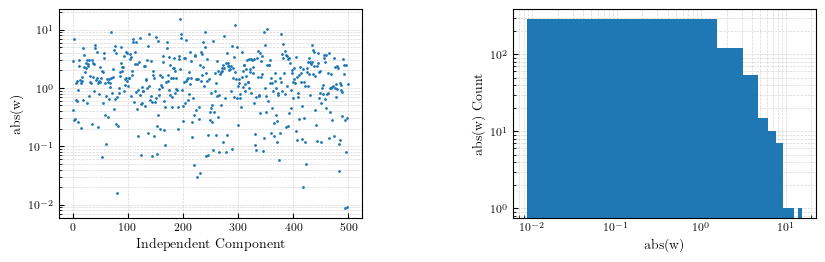

In [392]:
# plot the norm of each component of the weight vector
plot_metrics(np.abs(w), ylabel="abs(w)")

Figure size in inches:  [8.5 2.4]


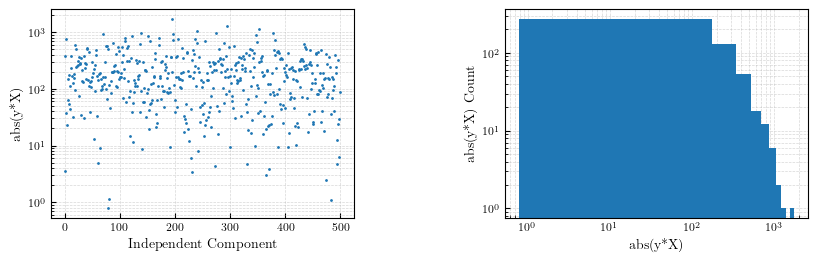

In [393]:
# compute y*X and sum over the data
yX = np.sum(y[:, np.newaxis] * X_tr, axis=0)
plot_metrics(abs(yX), ylabel="abs(y*X)")

Figure size in inches:  [8.5 2.4]


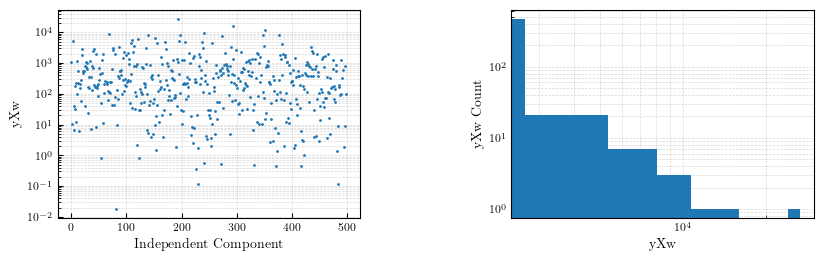

In [394]:

# compute y*X and sum over the data
yX = np.sum(y[:, np.newaxis] * X_tr, axis=0)
# compute elementwise yX * weights
yXw = yX * w
plot_metrics(yXw, ylabel="yXw")


Figure size in inches:  [8.5 2.4]


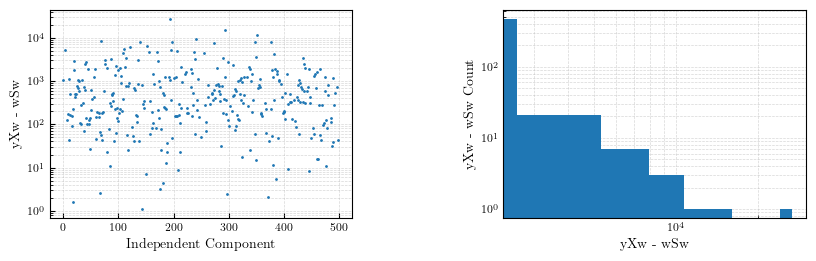

In [396]:
wSw = w.dot(sigma_upsilon).dot(w)
optimal_attack = attack_epsilon * np.sqrt(wSw)
# plot yXw - optimal_attack
attacked = yXw-optimal_attack
plot_metrics(attacked, ylabel="yXw - wSw")
